In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [2]:
# @param Does it save the figure ?
save_fig    = True
save_folder = 'UC2_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')


# @param Definition des table et colonnes --> Dépendent de la DB
DB             = "Archive2018_2019_prod"
TABLE_CONSO    = "Consommateur"
TABLE_ENTETE   = "Recette_entete_ticket"
TEMPS_ENTETE   = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE  = TABLE_ENTETE             + ".Numero_ticket"
TABLE_DETAIL   = "Recette_detail_ticket"
TEMPS_DETAIL   = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL  = TABLE_DETAIL             + ".Numero_ticket"
TABLE_ARTICLE  = "Article_meti_HIST"
TABLE_UNIVERS  = "Univers"

Univers_Depth  = 3            # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_client     = -1           # Nombre de clients à sélectionner. MAX = 148188. -1 --> ALL
client_tresh   = 20           # Nombre d'article que le client doit avoir acheter pour être mis dans un segment
univers_tresh  = 20           # Nombre d'article acheté de l'univers pour qu'il soit pris en compte

# @param Sur la normalization des données
Standard_Norm  = False        # Défini si on utilise la Normalization Standard
Standard_Tresh = 1            # Seuil d'acceptabilité des cluster en normalization standard
MinMax_Norm    = False        # Défini si on utilise la Normalization Minmax
MinMax_Tesh    = .3           # Seuil d'acceptabilité des cluster par défaut

# @param Sur le modèle KMean
K              = 21           # Nombre de segment. K = 21 -> 10% client d'exclu ; K = 15 -> 15% client exclu ; K = 9 -> 20% exclu 
n_init         = 50           # Nombre de run du KMean pour trouver le meilleur min

# @param Sur l'analyse des données
do_Elbow       = False         # Est-ce qu'on fait l'analyse des Elbow ou pas ?
Kmin           = 5            # Nombre de cluster au début de l'analyse
Kmax           = 30           # Nombre de cluster à la fin de l'analyse

In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_CONSO+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_CONSO+"]", conn)
print(df)

conn.close()

   Consommateur.KEY
0                -1
1                 1
2                 2
3                 3
4                 4
5                 5
6                 6
7                 7
8                 8
9                 9


# SEGMENTATION DE LA CLIENTELE

## Récupération des données correspondant aux clients

In [103]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + TABLE_ENTETE + '''.''' + TABLE_CONSO + '''.KEY] AS ''' + TABLE_CONSO + '''
FROM ['''       + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE + '''] 
ON    [''' + TEMPS_DETAIL  +'''] = [''' + TEMPS_ENTETE  + '''] 
AND   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
ON ['''    + TABLE_DETAIL  + '''.'''    + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
WHERE [''' + TABLE_ENTETE  + '''.'''    + TABLE_CONSO   + '''.KEY] > 0 '''
if nbr_client != -1:
    sql_command +=  ''' AND [''' + TABLE_ENTETE  +'''.'''     + TABLE_CONSO   + '''.KEY] < '''  + str(nbr_client)

print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 3min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)

SELECT [Article_meti_HIST.Univers.KEY] AS Univers
,[Recette_entete_ticket.Consommateur.KEY] AS Consommateur
FROM [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON    [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND   [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
ON [Recette_detail_ticket.Article_meti_HIST.KEY] = [Article_meti_HIST.KEY] 
WHERE [Recette_entete_ticket.Consommateur.KEY] > 0 


C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Time Taken to load DB: ~175secondes
10836528


In [104]:
start = time()

sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
    [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''
print(sql_command)

conn = engine.connect()
df_my_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 0s
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
print(df_my_univers)

SELECT [Univers.KEY] AS Univ_KEY,
    [Univers.Libelle_univers1_FR] AS Univ_1, 
    [Univers.Libelle_univers2_FR] AS Univ_2, 
    [Univers.Libelle_univers3_FR] AS Univ_3, 
    [Univers.Libelle_univers4_FR] AS Univ_4
    FROM [Archive2018_2019_prod].[DWH].[Dim_Univers]
Time Taken to load DB: ~0secondes
     Univ_KEY                      Univ_1                  Univ_2  \
0          -1                           ?                       ?   
1           1               PRET A MANGER  SERVICE TRAITEUR FROID   
2           2               PRET A MANGER            MEUBLE CHAUD   
3           3               PRET A MANGER            MEUBLE CHAUD   
4           4               PRET A MANGER            MEUBLE CHAUD   
..        ...                         ...                     ...   
485       485               PRET A MANGER                 SALADES   
486       486               PRET A MANGER                 SALADES   
487       487  APERITIF   ENTREES   TAPAS                   TAPAS   
488    

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [105]:
univers_correspondance = {}
deleted = set()
for item in df_my_univers.values:
    if item[0] in deleted:
        continue
    for cor in df_my_univers.values: 
        if item[0] != cor[0]:
            if (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
                deleted.add(cor[0])
print(univers_correspondance)

{428: 1, 429: 1, 3: 2, 4: 2, 5: 2, 8: 7, 28: 27, 32: 31, 39: 38, 40: 38, 42: 41, 43: 41, 44: 41, 46: 45, 47: 45, 48: 45, 49: 45, 50: 45, 462: 51, 475: 51, 62: 61, 63: 61, 71: 70, 72: 70, 73: 70, 89: 88, 90: 88, 91: 88, 93: 92, 456: 125, 463: 125, 464: 125, 465: 125, 466: 125, 467: 125, 468: 125, 130: 129, 137: 136, 139: 138, 140: 138, 181: 180, 182: 180, 183: 180, 184: 180, 185: 180, 186: 180, 187: 180, 469: 213, 476: 213, 216: 215, 218: 217, 225: 224, 227: 226, 457: 228, 458: 228, 459: 228, 470: 228, 477: 228, 471: 229, 472: 229, 245: 244, 246: 244, 247: 244, 248: 244, 249: 244, 250: 244, 251: 244, 252: 244, 253: 244, 254: 244, 255: 244, 256: 244, 281: 280, 282: 280, 283: 280, 454: 322, 473: 322, 461: 325, 474: 325, 487: 327, 488: 327, 345: 344, 347: 346, 349: 348, 350: 348, 351: 348, 352: 348, 353: 348, 354: 348, 356: 355, 357: 355, 358: 355, 359: 355, 360: 355, 361: 355, 363: 362, 364: 362, 390: 362, 391: 362, 393: 392, 394: 392, 395: 392, 396: 392, 397: 392, 398: 392, 399: 392, 400

In [106]:
start = time()
dict_client_univ = {}

for i in range(nbr_data):
    univ   = df_univers[TABLE_UNIVERS][i]
    client = df_univers[TABLE_CONSO][i]
    if univ == -1:
        continue
    
    if univ in deleted:
        univ = univers_correspondance[univ]
    
    if not client in dict_client_univ:
        dict_client_univ[client] = {}
        
    if not univ in dict_client_univ[client]:
        dict_client_univ[client][univ] = 0
    dict_client_univ[client][univ] += 1

to_remove = []
for k,v in dict_client_univ.items():
    if sum(v.values()) < client_tresh:
        to_remove.append(k)
    else:
        maxi = max(v.values())
        dict_client_univ[k] = {key:value/maxi for key,value in v.items()}

for k in to_remove:
    del dict_client_univ[k]
        
    
clients_data = pd.DataFrame(index = dict_client_univ.keys(),
                        data = dict_client_univ.values())
clients_data = clients_data.replace(float('NaN'), 0)
 
print(clients_data)

# environ 10s * nbr_client/10.000
print("Time Taken to load Dataframe: ~" + str(int(time() - start)) + "secondes")

             196       299       211       19        180       61        228  \
54086   0.043478  1.000000  0.500000  0.065217  0.130435  0.043478  0.065217   
32784   0.025641  0.025641  0.025641  0.000000  0.256410  0.000000  0.102564   
98450   0.000000  0.434783  0.043478  0.000000  0.086957  0.000000  0.391304   
84764   0.000000  0.276543  0.024691  0.004938  0.049383  0.034568  0.128395   
74979   0.000000  0.042389  0.125241  0.000000  0.146435  0.009634  0.040462   
...          ...       ...       ...       ...       ...       ...       ...   
145648  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
143493  0.000000  0.333333  0.000000  0.000000  0.000000  0.000000  0.000000   
87061   0.000000  0.000000  0.166667  0.000000  0.166667  0.000000  0.000000   
148172  0.000000  0.000000  0.000000  0.000000  0.000000  0.500000  0.000000   
147671  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   

             52        297       176  .

In [107]:
# Standard Normalization
def standard_normalization(df):
    return df.iloc[:,:].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

# Min-Max Normalization
from sklearn.preprocessing import MinMaxScaler
def minmax_normalization(df):
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(df) 
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

norm_clients_data = clients_data
if Standard_Norm:
    norm_clients_data = standard_normalization(norm_clients_data)
if MinMax_Norm:
    norm_clients_data = minmax_normalization(norm_clients_data)

for column in norm_clients_data:
    if sum(norm_clients_data[column]) < univers_tresh:
        norm_clients_data = norm_clients_data.drop(columns = column)

print(norm_clients_data)

             196       299       211       19        180       61        228  \
54086   0.043478  1.000000  0.500000  0.065217  0.130435  0.043478  0.065217   
32784   0.025641  0.025641  0.025641  0.000000  0.256410  0.000000  0.102564   
98450   0.000000  0.434783  0.043478  0.000000  0.086957  0.000000  0.391304   
84764   0.000000  0.276543  0.024691  0.004938  0.049383  0.034568  0.128395   
74979   0.000000  0.042389  0.125241  0.000000  0.146435  0.009634  0.040462   
...          ...       ...       ...       ...       ...       ...       ...   
145648  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
143493  0.000000  0.333333  0.000000  0.000000  0.000000  0.000000  0.000000   
87061   0.000000  0.000000  0.166667  0.000000  0.166667  0.000000  0.000000   
148172  0.000000  0.000000  0.000000  0.000000  0.000000  0.500000  0.000000   
147671  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   

             52        297       176  .

5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

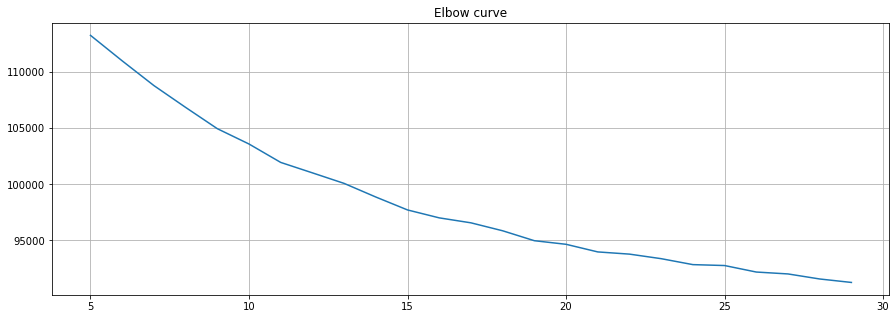

Time Taken to generate Elbow Curve : ~311secondes


In [119]:
if do_Elbow:
    start = time()
    
    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(norm_clients_data)
        distorsions.append(model.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Elbow_Curve.jpg")
    
    plt.show()
    # environ 10s*Kmax
    print("Time Taken to generate Elbow Curve : ~" + str(int(time() - start)) + "secondes")

5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

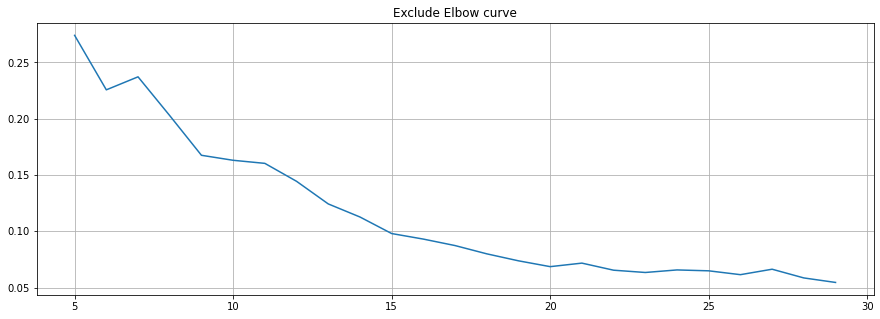

Time Taken to generate Exclude Elbow Curve : ~329secondes


In [115]:
if do_Elbow:
    start = time()

    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(norm_clients_data)
        cluster = model.predict(norm_clients_data)
        cluster_centers = model.cluster_centers_

        treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh
        NACK = 0
        for i in range(len(cluster_centers)):
            if sum([(1 if c > treshold else 0) for c in cluster_centers[i]]) == 0:
                NACK += cluster.tolist().count(i)

        distorsions.append(NACK/len(cluster))

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Exclude Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Exclude_Elbow_Curve.jpg")
    
    plt.show()
    

    # environ 10s*Kmax
    print("Time Taken to generate Exclude Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [110]:
start = time()
model = KMeans(K, n_init = n_init)
model.fit(norm_clients_data)
cluster = model.labels_
# environ 1.5s * n_init
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~78secondes


In [111]:
cluster_centers = model.cluster_centers_

interest = {i:[] for i in range(len(cluster_centers))}

treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh

for i in range(len(cluster_centers)):
    for j in range(len(cluster_centers[i])):
        if cluster_centers[i][j] > treshold:
            interest[i].append(clients_data.columns[j])

In [112]:
NACK = 0

conn = engine.connect()
for key,values in interest.items():
    print("\n\nCluster", key, end=': ')
    proportion = cluster.tolist().count(key)*100/len(cluster)
    print(round(proportion,2),"%",)
    
    if len(values) == 0:
        NACK += proportion
        continue
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in values:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]
    #print(sql_command)

    df_libele = pd.read_sql(sql_command, conn)
    print(df_libele.to_string(index=False))
conn.close()

print("\nNACK =", round(NACK,2),"%")



Cluster 0: 3.22 %
 Univ_KEY        Univ_1         Univ_2        Univ_3
      402 PRET A MANGER PLATS PREPARES  CHINESE FOOD
      408 PRET A MANGER PLATS PREPARES JAPANESE FOOD
      412 PRET A MANGER PLATS PREPARES     THAI FOOD


Cluster 1: 3.87 %
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Cluster 2: 1.82 %
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES
      437 PETIT DEJEUNER CAFE SERVICE  CAFE SERVICE


Cluster 3: 6.43 %
 Univ_KEY        Univ_1         Univ_2         Univ_3
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD


Cluster 4: 4.65 %
 Univ_KEY         Univ_1                       Univ_2 Univ_3
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS


Cluster 5: 6.94 %


Cluster 6: 4.83 %
 Univ_KEY         Univ_1       Univ_2            Univ_3
      299 PETIT DEJEUNER VIENNOISERIE     VIENNOISERIES
      392 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqli

In [113]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~373secondes
